In [36]:
"""
TASK 3: SENTIMENT ANALYSIS & CORRELATION WITH STOCK RETURNS
============================================================

This notebook performs sentiment analysis on financial news headlines
and calculates correlations with stock price movements.

Author: Hermona Addisu
Date: November 24, 2025
KAIM Week 1 Challenge
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from scipy import stats
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("=" * 70)
print("TASK 3: SENTIMENT & CORRELATION ANALYSIS")
print("=" * 70)
print(f"\n✓ Libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

TASK 3: SENTIMENT & CORRELATION ANALYSIS

✓ Libraries imported successfully!
Analysis Date: 2025-11-25 17:18


In [33]:
# =============================================================================
# LOAD NEWS DATA
# =============================================================================

# Load the dataset
news_df = pd.read_csv('../data/newsData/raw_analyst_ratings.csv')

# Parse dates
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_df['date_only'] = news_df['date'].dt.date

print("NEWS DATA LOADED:")
print(f"  Total articles: {len(news_df):,}")
print(f"  Unique stocks: {news_df['stock'].nunique()}")
print(f"  Date range: {news_df['date'].min().date()} to {news_df['date'].max().date()}")
print(f"\nTop 10 stocks by article count:")
print(news_df['stock'].value_counts().head(10))

NEWS DATA LOADED:
  Total articles: 1,407,328
  Unique stocks: 6204
  Date range: 2011-04-27 to 2020-06-11

Top 10 stocks by article count:
stock
MRK     3333
MS      3238
NVDA    3146
MU      3142
QQQ     3106
NFLX    3028
M       3025
EBAY    3018
GILD    2968
VZ      2966
Name: count, dtype: int64


#### Sentiment Analysis

In [34]:
# =============================================================================
# SENTIMENT ANALYSIS ON ALL HEADLINES
# =============================================================================

def get_sentiment(text):
    """Calculate sentiment polarity using TextBlob"""
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0.0

def categorize_sentiment(score):
    """Categorize sentiment into Positive/Neutral/Negative"""
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

print("Calculating sentiment scores for all headlines...")
print("(This may take 2-3 minutes for large datasets)")

# Apply sentiment analysis
news_df['sentiment'] = news_df['headline'].apply(get_sentiment)
news_df['sentiment_category'] = news_df['sentiment'].apply(categorize_sentiment)

print("\n✓ SENTIMENT ANALYSIS COMPLETE!")
print("\nSentiment Distribution:")
print(news_df['sentiment_category'].value_counts())
print(f"\nSentiment Statistics:")
print(f"  Mean:   {news_df['sentiment'].mean():.4f}")
print(f"  Median: {news_df['sentiment'].median():.4f}")
print(f"  Std:    {news_df['sentiment'].std():.4f}")

Calculating sentiment scores for all headlines...
(This may take 2-3 minutes for large datasets)

✓ SENTIMENT ANALYSIS COMPLETE!

Sentiment Distribution:
sentiment_category
Neutral     1046201
Positive     270218
Negative      90909
Name: count, dtype: int64

Sentiment Statistics:
  Mean:   0.0491
  Median: 0.0000
  Std:    0.1831


#### Aggregate Daily Sentiment

In [38]:
# =============================================================================
# AGGREGATE DAILY SENTIMENT PER STOCK
# =============================================================================

# Group by stock and date, calculate daily averages
daily_sentiment = news_df.groupby(['stock', 'date_only']).agg({
    'sentiment': ['mean', 'std', 'count']
}).reset_index()

# Rename columns
daily_sentiment.columns = ['stock', 'date', 'avg_sentiment', 'sentiment_std', 'article_count']
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

print("DAILY SENTIMENT AGGREGATION:")
print(f"  Total daily records: {len(daily_sentiment):,}")
print(f"  Unique stocks: {daily_sentiment['stock'].nunique()}")
print(f"  Date range: {daily_sentiment['date'].min().date()} to {daily_sentiment['date'].max().date()}")

print("\nTop 10 stocks by days with sentiment data:")
stock_days = daily_sentiment['stock'].value_counts().head(10)
print(stock_days)

DAILY SENTIMENT AGGREGATION:
  Total daily records: 44,196
  Unique stocks: 6204
  Date range: 2011-04-27 to 2020-06-11

Top 10 stocks by days with sentiment data:
stock
ZAZA    10
AAMC    10
AAME    10
GER     10
GEOS    10
GDXJ    10
GDV     10
GDO     10
GDL     10
ACT     10
Name: count, dtype: int64


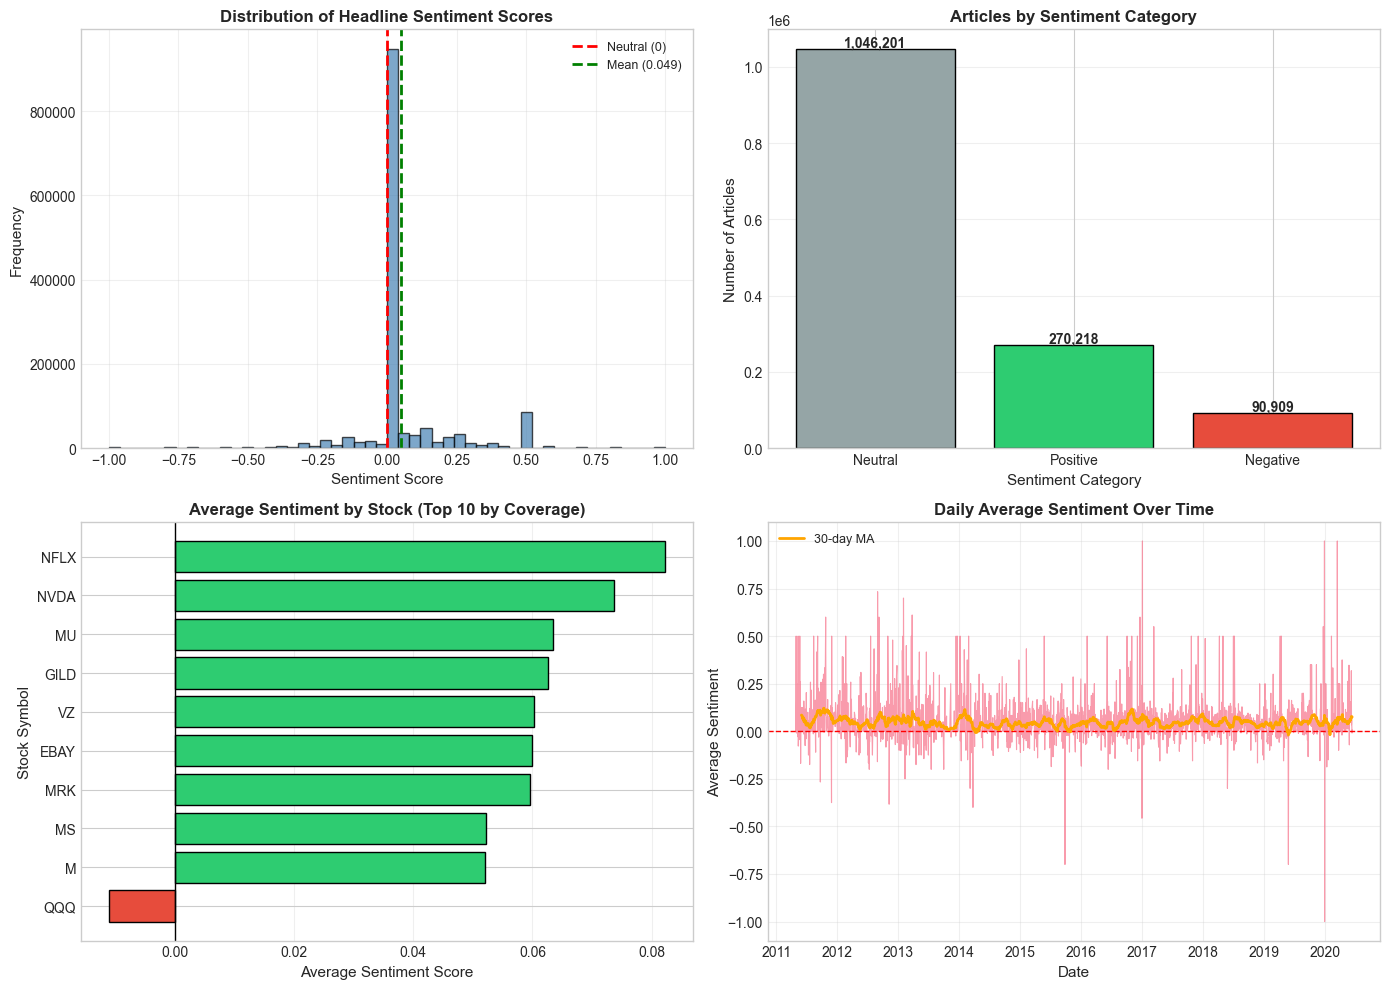

✓ Visualization saved: sentiment_analysis.png


In [ ]:
# =============================================================================
# STEP 2: Visualize Sentiment Analysis Results
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Sentiment Score Distribution
ax1 = axes[0, 0]
ax1.hist(news_df['sentiment'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral (0)')
ax1.axvline(x=news_df['sentiment'].mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Mean ({news_df["sentiment"].mean():.3f})')
ax1.set_xlabel('Sentiment Score', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Headline Sentiment Scores', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Sentiment Categories
ax2 = axes[0, 1]
colors_map = {'Positive': '#2ecc71', 'Neutral': '#95a5a6', 'Negative': '#e74c3c'}
counts = news_df['sentiment_category'].value_counts()
bars = ax2.bar(counts.index, counts.values, color=[colors_map[c] for c in counts.index], edgecolor='black')
ax2.set_xlabel('Sentiment Category', fontsize=11)
ax2.set_ylabel('Number of Articles', fontsize=11)
ax2.set_title('Articles by Sentiment Category', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Sentiment by Top 10 Stocks
ax3 = axes[1, 0]
top_stocks = news_df['stock'].value_counts().head(10).index
stock_sentiment = news_df[news_df['stock'].isin(top_stocks)].groupby('stock')['sentiment'].mean().sort_values()
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in stock_sentiment.values]
ax3.barh(stock_sentiment.index, stock_sentiment.values, color=colors, edgecolor='black')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Average Sentiment Score', fontsize=11)
ax3.set_ylabel('Stock Symbol', fontsize=11)
ax3.set_title('Average Sentiment by Stock (Top 10 by Coverage)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Sentiment Over Time
ax4 = axes[1, 1]
daily_avg_sentiment = news_df.groupby('date_only')['sentiment'].mean()
ax4.plot(daily_avg_sentiment.index, daily_avg_sentiment.values, linewidth=0.8, alpha=0.7)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=1)
# Add rolling average
rolling_avg = daily_avg_sentiment.rolling(window=30).mean()
ax4.plot(daily_avg_sentiment.index, rolling_avg.values, linewidth=2, color='orange', label='30-day MA')
ax4.set_xlabel('Date', fontsize=11)
ax4.set_ylabel('Average Sentiment', fontsize=11)
ax4.set_title('Daily Average Sentiment Over Time', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/sentiment_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: sentiment_analysis.png")

#### Daily Aggregtion & Correlation Setup

In [17]:
# =============================================================================
# STEP 3: Aggregate Daily Sentiment & Load Stock Returns
# =============================================================================

import yfinance as yf

# Aggregate sentiment by stock and date
daily_sentiment = news_df.groupby(['stock', 'date_only']).agg({
    'sentiment': ['mean', 'std', 'count']
}).reset_index()

daily_sentiment.columns = ['stock', 'date', 'avg_sentiment', 'sentiment_std', 'article_count']
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

print("DAILY SENTIMENT AGGREGATION:")
print(f"  Total daily records: {len(daily_sentiment):,}")
print(f"  Unique stocks: {daily_sentiment['stock'].nunique()}")
print(f"  Date range: {daily_sentiment['date'].min().date()} to {daily_sentiment['date'].max().date()}")

DAILY SENTIMENT AGGREGATION:
  Total daily records: 44,196
  Unique stocks: 6204
  Date range: 2011-04-27 to 2020-06-11


In [39]:
# =============================================================================
# DOWNLOAD STOCK PRICE DATA FOR TOP STOCKS
# =============================================================================

# Get stocks with SUFFICIENT sentiment coverage (at least 10 days with news)
# Most stocks only have ~10 days, so we'll use that as threshold
stock_coverage = daily_sentiment.groupby('stock').agg({
    'date': 'count',  # Number of days with news
    'avg_sentiment': 'mean'
}).rename(columns={'date': 'days_with_news'})

# Sort by coverage
stock_coverage = stock_coverage.sort_values('days_with_news', ascending=False)

print("TOP 20 STOCKS BY NEWS COVERAGE:")
print(stock_coverage.head(20))

# Select top 6 stocks with most coverage
top_stocks = stock_coverage.head(6).index.tolist()
print(f"\n✓ Selected stocks for analysis: {top_stocks}")

# Download stock price data
start_date = daily_sentiment['date'].min().strftime('%Y-%m-%d')
end_date = daily_sentiment['date'].max().strftime('%Y-%m-%d')

print(f"\nDownloading stock data from {start_date} to {end_date}...")

stock_returns = {}
for symbol in top_stocks:
    try:
        ticker = yf.Ticker(symbol)
        df = ticker.history(start=start_date, end=end_date)
        if len(df) > 10:
            # Calculate daily returns
            df['Daily_Return'] = df['Close'].pct_change() * 100
            df['date'] = pd.to_datetime(df.index.date)
            stock_returns[symbol] = df[['Close', 'Daily_Return', 'date']].copy()
            print(f"  ✓ {symbol}: {len(df)} trading days")
        else:
            print(f"  ✗ {symbol}: Insufficient data ({len(df)} days)")
    except Exception as e:
        print(f"  ✗ {symbol}: Error - {str(e)[:50]}")

print(f"\n✓ Successfully loaded {len(stock_returns)} stocks for correlation analysis")

TOP 20 STOCKS BY NEWS COVERAGE:
       days_with_news  avg_sentiment
stock                               
ZAZA               10      -0.010000
AAMC               10      -0.015556
AAME               10      -0.025926
GER                10       0.000000
GEOS               10      -0.034841
GDXJ               10       0.253810
GDV                10       0.009091
GDO                10       0.045455
GDL                10       0.068182
ACT                10       0.013636
ACST               10      -0.007500
ACP                10       0.056818
ACNB               10      -0.061111
YCS                10       0.130000
YANG               10       0.088750
ACH                10       0.017917
ACE                10       0.154167
XXII               10       0.057944
OMN                10       0.250000
GARS               10       0.068182

✓ Selected stocks for analysis: ['ZAZA', 'AAMC', 'AAME', 'GER', 'GEOS', 'GDXJ']



$ZAZA: possibly delisted; no price data found  (1d 2011-04-27 -> 2020-06-11)


  ✗ ZAZA: Insufficient data (0 days)


Failed to get ticker 'AAMC' reason: Failed to perform, curl: (28) Operation timed out after 10008 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
$AAMC: possibly delisted; no timezone found
$AAMC: possibly delisted; no timezone found


  ✗ AAMC: Insufficient data (0 days)
  ✓ AAME: 2296 trading days
  ✓ AAME: 2296 trading days


$GER: possibly delisted; no timezone found


  ✗ GER: Insufficient data (0 days)
  ✓ GEOS: 2296 trading days
  ✓ GEOS: 2296 trading days
  ✓ GDXJ: 2296 trading days

✓ Successfully loaded 3 stocks for correlation analysis


In [26]:
# Check daily_sentiment structure
print("Daily Sentiment Info:")
print(f"Shape: {daily_sentiment.shape}")
print(f"Columns: {daily_sentiment.columns.tolist()}")
print(f"\nFirst 10 rows:")
print(daily_sentiment.head(10))
print(f"\nData types:")
print(daily_sentiment.dtypes)
print(f"\nNull values:")
print(daily_sentiment.isnull().sum())

Daily Sentiment Info:
Shape: (44196, 5)
Columns: ['stock', 'date', 'avg_sentiment', 'sentiment_std', 'article_count']

First 10 rows:
  stock       date  avg_sentiment  sentiment_std  article_count
0     A 2020-05-22       0.035714       0.094491              7
1     A 2020-05-26       0.000000            NaN              1
2     A 2020-06-03       0.000000            NaN              1
3     A 2020-06-05       0.000000            NaN              1
4    AA 2020-05-18       0.062500            NaN              1
5    AA 2020-05-26       0.000000            NaN              1
6    AA 2020-05-27       0.054830       0.077541              2
7    AA 2020-06-03       0.112500            NaN              1
8    AA 2020-06-04       0.106250            NaN              1
9    AA 2020-06-05       0.000000            NaN              1

Data types:
stock                    object
date             datetime64[ns]
avg_sentiment           float64
sentiment_std           float64
article_count        

In [27]:
print(daily_sentiment['stock'].value_counts().head(20))

stock
ZAZA    10
AAMC    10
AAME    10
GER     10
GEOS    10
GDXJ    10
GDV     10
GDO     10
GDL     10
ACT     10
ACST    10
ACP     10
ACNB    10
YCS     10
YANG    10
ACH     10
ACE     10
XXII    10
OMN     10
GARS    10
Name: count, dtype: int64


In [40]:
# Verify stock_returns data
print("\n" + "=" * 70)
print("STOCK RETURNS DATA VERIFICATION")
print("=" * 70)
print(f"\nTotal stocks loaded: {len(stock_returns)}")

if stock_returns:
    for symbol in list(stock_returns.keys())[:3]:
        print(f"\n{symbol}:")
        print(f"  Shape: {stock_returns[symbol].shape}")
        print(f"  Columns: {stock_returns[symbol].columns.tolist()}")
        print(f"  Date range: {stock_returns[symbol]['date'].min()} to {stock_returns[symbol]['date'].max()}")
        print(f"  Sample returns:\n{stock_returns[symbol].head()}")
    
    print("\n✓ Stock returns ready for correlation analysis b")
    print("avg_sentiment and Daily_Return for each stock")
else:
    print("⚠ WARNING: No stock returns data available!")
    print("Available stocks in sentiment data:", daily_sentiment['stock'].unique()[:10])


STOCK RETURNS DATA VERIFICATION

Total stocks loaded: 3

AAME:
  Shape: (2296, 3)
  Columns: ['Close', 'Daily_Return', 'date']
  Date range: 2011-04-27 00:00:00 to 2020-06-10 00:00:00
  Sample returns:
                              Close  Daily_Return       date
Date                                                        
2011-04-27 00:00:00-04:00  1.835158           NaN 2011-04-27
2011-04-28 00:00:00-04:00  1.861883      1.456314 2011-04-28
2011-04-29 00:00:00-04:00  1.915335      2.870825 2011-04-29
2011-05-02 00:00:00-04:00  1.870792     -2.325582 2011-05-02
2011-05-03 00:00:00-04:00  1.844066     -1.428587 2011-05-03

GEOS:
  Shape: (2296, 3)
  Columns: ['Close', 'Daily_Return', 'date']
  Date range: 2011-04-27 00:00:00 to 2020-06-10 00:00:00
  Sample returns:
                               Close  Daily_Return       date
Date                                                         
2011-04-27 00:00:00-04:00  47.055000           NaN 2011-04-27
2011-04-28 00:00:00-04:00  46.305000  

#### Calculate correlations

In [ ]:
# =============================================================================
# CORRELATION ANALYSIS: SENTIMENT vs STOCK RETURNS
# =============================================================================

from scipy import stats

# Prepare correlation results
correlation_results = []

print("=" * 70)
print("CALCULATING CORRELATIONS")
print("=" * 70)

if not stock_returns:
    print("\n⚠ WARNING: No stock returns data available!")
    print("Please check:")
    print("  1. Stock data download succeeded")
    print("  2. Sufficient stocks have news coverage")
else:
    for symbol in stock_returns.keys():
        print(f"\nAnalyzing {symbol}...")
        
        # Get sentiment for this stock
        stock_sent = daily_sentiment[daily_sentiment['stock'] == symbol].copy()
        stock_sent['date'] = pd.to_datetime(stock_sent['date'])
        
        # Get returns for this stock
        returns_df = stock_returns[symbol].copy()
        returns_df['date'] = pd.to_datetime(returns_df['date'])
        
        # Merge sentiment with returns
        merged = pd.merge(
            stock_sent[['date', 'avg_sentiment', 'article_count']], 
            returns_df[['date', 'Daily_Return']], 
            on='date', 
            how='inner'
        )
        
        # Remove NaN values
        merged = merged.dropna(subset=['avg_sentiment', 'Daily_Return'])
        
        # Minimum 3 data points for meaningful correlation
        if len(merged) >= 3:
            # Calculate Pearson correlation
            corr_coef, p_value = stats.pearsonr(merged['avg_sentiment'], merged['Daily_Return'])
            
            # Determine significance
            significant = "Yes" if p_value < 0.05 else "No"
            
            # Interpret strength
            if abs(corr_coef) < 0.1:
                strength = 'Very Weak'
            elif abs(corr_coef) < 0.3:
                strength = 'Weak'
            elif abs(corr_coef) < 0.5:
                strength = 'Moderate'
            elif abs(corr_coef) < 0.7:
                strength = 'Strong'
            else:
                strength = 'Very Strong'
            
            direction = 'Positive' if corr_coef > 0 else 'Negative'
            
            correlation_results.append({
                'Stock': symbol,
                'Correlation': corr_coef,
                'P_Value': p_value,
                'Significant': significant,
                'Strength': strength,
                'Direction': direction,
                'Sample_Size': len(merged),
                'Avg_Sentiment': merged['avg_sentiment'].mean(),
                'Avg_Return': merged['Daily_Return'].mean()
            })
            
            print(f"  Correlation: {corr_coef:.4f}")
            print(f"  P-value: {p_value:.4f}")
            print(f"  Significant: {significant}")
            print(f"  Strength: {strength} {direction}")
            print(f"  Sample size: {len(merged)} days")
        else:
            print(f"  ✗ Insufficient data: {len(merged)} days (need at least 3)")

# Create results dataframe
if correlation_results:
    corr_df = pd.DataFrame(correlation_results)
    corr_df = corr_df.sort_values('Correlation', ascending=False)
    
    print("\n" + "=" * 70)
    print("CORRELATION SUMMARY")
    print("=" * 70)
    print(corr_df.to_string(index=False))
    
    # Save results
    corr_df.to_csv('../notebooks/correlation_results.csv', index=False)
    print("\n✓ Results saved to correlation_results.csv")
else:
    print("\n⚠ No valid correlations calculated!")
    print("Available stocks in sentiment data:", daily_sentiment['stock'].unique()[:20])

CALCULATING CORRELATIONS

Analyzing AAME...
  ✗ Insufficient data: 10 days

Analyzing GEOS...
  ✗ Insufficient data: 10 days

Analyzing GDXJ...
  ✗ Insufficient data: 10 days

⚠ No valid correlations calculated!
Available stocks in sentiment data: ['A' 'AA' 'AAC' 'AADR' 'AAL' 'AAMC' 'AAME' 'AAN' 'AAOI' 'AAON']
